# Detecting Coronary Heart Disease in Adults Using a ML Classifier

## Introduction
Heart disease is the leading cause of death in the United States. It causes a significant loss of life, strain on the healthcare system and billions of dollars every year. Coronary Artery Disease (CAD) is the most common type of heart disease. Here we use data from the 2013-2014 National Health and Examination Survey (NHANES) and select features to train a machine learning model that will be able to detect the posible presence of CAD in adults. Three differint classification models are trained and to compare performance.


### Data Retreival and  Inital Set Up

The data was retreived from the 2013-2014 NHANES Survey. Information about this data can be found [here](https://www.cdc.gov/nchs/data/nhanes/nhanes_13_14/2013-14_overview_brochure.pdf). The data is grouped into 5 main areas: Demographic Data, Dietary Data, Examination Data, Laboratory Data, Questionaire Data. Each was extracted and loaded into a SQlite Database as separate tables. The [variable descriptions](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2013) were scraped using python and saved in a separate database for easier data understanding and querying. The variable description database is located github in the ["NHANES SQLite DBs"](https://github.com/chrchristensen1/Deloitte-AI-Acadaemy-Final-Capstone-Project/tree/main/Data/NHANES%20SQLite%20DBs) folder.

## Data Cleaning and Preparation for Modeling
In this section the data is cleaned, manipulated, and prepared to be model ready.
#### Imports and Dependencies
Imports included many standard python libraries as well as many scikit-learn libraries.

In [57]:
#Importing necessary python libraries
import sqlite3
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model  import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, fbeta_score, make_scorer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
%matplotlib inline

#### SQLite Database Connection and Data Queries
Here the SQLite database is queried to retrieve the desired features. The [Variable Description Database](https://github.com/chrchristensen1/Deloitte-AI-Acadaemy-Final-Capstone-Project/blob/main/Data/NHANES%20SQLite%20DBs/2013-2014%20NHANES%20Survey%20Varible%20Lists.db) was queried prior to determine fields that could be used for modeling as well as the target feature. The fields that were included were basic demographic data as well as information that are considered risk factors for CAD such as Cholesterol, Smoking, Diabetes, a Sedentary lifestyle etc.

In [58]:
# connect to SQlite NHANES DB and read in necessary data.
con = sqlite3.connect("../data/NHANES SQLite DBs/2013-2014 NHANES Survey.db")
query = """

SELECT

SEQN, RIDAGEYR, RIAGENDR, BMXHT, BMXWT, BMXBMI, RIDRETH1, BPXDI1, 
BPXDI2, BPXDI3, BPXDI4, BPXSY1, BPXSY2, BPXSY3, BPXSY4, BPXCHR,
BPXPLS, BPXPULS, LBDHDD, LBDLDL, LBXTC, LBXTR, LBXSGL,
MCQ300a, PAD680, SMQ040,SMQ020, DIQ010, MCQ160e, MCQ160c

FROM demographic
JOIN examination
    USING(SEQN)
JOIN labs
    USING(SEQN)
JOIN questionnaire
    USING(SEQN)
;
"""
cad_df = pd.read_sql(query, con)

#Close SQLite DB connections
con.close()

#View DataFrame
cad_df.head()

,SEQN,RIDAGEYR,RIAGENDR,BMXHT,BMXWT,BMXBMI,RIDRETH1,BPXDI1,BPXDI2,BPXDI3,...,LBXTC,LBXTR,LBXSGL,MCQ300A,PAD680,SMQ040,SMQ020,DIQ010,MCQ160E,MCQ160C
0,73557,69,1,171.3,78.3,26.7,4,72,76,74,...,167,None,554,2,600,3,1,1,2,2
1,73558,54,1,176.8,89.5,28.6,3,62,80,42,...,170,None,219,2,540,2,1,1,2,2
2,73559,72,1,175.3,88.9,28.9,3,90,76,80,...,126,51,183,1,300,3,1,1,2,2
3,73560,9,1,137.3,32.2,17.1,3,38,34,38,...,168,None,None,None,None,None,None,2,None,None
4,73561,73,2,162.4,52.0,19.7,3,86,88,86,...,201,75,104,1,480,None,2,2,2,2


#### Rename Columns
Here the columns are renamed to be easier to work with them. This process was aided by the [variable description](https://github.com/chrchristensen1/Deloitte-AI-Acadaemy-Final-Capstone-Project/blob/main/Data/NHANES%20SQLite%20DBs/2013-2014%20NHANES%20Survey%20Varible%20Lists.db) database found in the github repository.

In [59]:
# rename columns
col_rename ={
'RIDAGEYR': 'Age', 'RIAGENDR': 'Gender', 'BMXHT': 'HT', 'BMXWT': 'WT', 'BMXBMI': 'BMI','RIDRETH1': 'Race', 
'BPXDI1': 'DBP_1', 'BPXDI2': 'DBP_2', 'BPXDI3': 'DBP_3', 'BPXDI4': 'DBP_4', 'BPXSY1': 'SBP_1', 'BPXSY2': 'SBP_2', 
'BPXSY3': 'SBP_3', 'BPXSY4': 'SBP_4', 'BPXCHR': 'HR', 'BPXPLS': 'Pulse', 'BPXPULS': 'Arrhythmia', 'LBDHDD': 'HDL', 
'LBDLDL': 'LDL', 'LBXTC': 'TC', 'LBXTR': 'TG', 'LBXSGL': 'Glu', 'MCQ300A': 'FH_MI', 'PAD680': 'DTS',
'SMQ040': 'Smoker', 'SMQ020': 'Smoked_100','DIQ010': 'DM', 'MCQ160E': 'MI', 'MCQ160C': 'CAD'
}
cad_df.rename(columns=col_rename, inplace=True)
cad_df.head()

,SEQN,Age,Gender,HT,WT,BMI,Race,DBP_1,DBP_2,DBP_3,...,TC,TG,Glu,FH_MI,DTS,Smoker,Smoked_100,DM,MI,CAD
0,73557,69,1,171.3,78.3,26.7,4,72,76,74,...,167,None,554,2,600,3,1,1,2,2
1,73558,54,1,176.8,89.5,28.6,3,62,80,42,...,170,None,219,2,540,2,1,1,2,2
2,73559,72,1,175.3,88.9,28.9,3,90,76,80,...,126,51,183,1,300,3,1,1,2,2
3,73560,9,1,137.3,32.2,17.1,3,38,34,38,...,168,None,None,None,None,None,None,2,None,None
4,73561,73,2,162.4,52.0,19.7,3,86,88,86,...,201,75,104,1,480,None,2,2,2,2


#### Change Data Types
The null values in these databases were "None" values rather than the Numpy "NaN" values making it difficult to to arithmetic manipulation without removing them prior. It was decided to change all "None" values to "NaN" values for easier manipulation.

In [60]:
#Replace none with NaN for easier manipulation
cad_df.fillna(value=np.nan, inplace=True)

#Convert to floats to allow for arithmetic with NaNs
cad_df = cad_df.astype(float)
cad_df.head()

,SEQN,Age,Gender,HT,WT,BMI,Race,DBP_1,DBP_2,DBP_3,...,TC,TG,Glu,FH_MI,DTS,Smoker,Smoked_100,DM,MI,CAD
0,73557.0,69.0,1.0,171.3,78.3,26.7,4.0,72.0,76.0,74.0,...,167.0,NaN,554.0,2.0,600.0,3.0,1.0,1.0,2.0,2.0
1,73558.0,54.0,1.0,176.8,89.5,28.6,3.0,62.0,80.0,42.0,...,170.0,NaN,219.0,2.0,540.0,2.0,1.0,1.0,2.0,2.0
2,73559.0,72.0,1.0,175.3,88.9,28.9,3.0,90.0,76.0,80.0,...,126.0,51.0,183.0,1.0,300.0,3.0,1.0,1.0,2.0,2.0
3,73560.0,9.0,1.0,137.3,32.2,17.1,3.0,38.0,34.0,38.0,...,168.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,73561.0,73.0,2.0,162.4,52.0,19.7,3.0,86.0,88.0,86.0,...,201.0,75.0,104.0,1.0,480.0,NaN,2.0,2.0,2.0,2.0


In [61]:
# View df.info to get a better understanding of the data
cad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SEQN        9813 non-null   float64
 1   Age         9813 non-null   float64
 2   Gender      9813 non-null   float64
 3   HT          9067 non-null   float64
 4   WT          9723 non-null   float64
 5   BMI         9055 non-null   float64
 6   Race        9813 non-null   float64
 7   DBP_1       7172 non-null   float64
 8   DBP_2       7409 non-null   float64
 9   DBP_3       7408 non-null   float64
 10  DBP_4       515 non-null    float64
 11  SBP_1       7172 non-null   float64
 12  SBP_2       7409 non-null   float64
 13  SBP_3       7408 non-null   float64
 14  SBP_4       515 non-null    float64
 15  HR          1961 non-null   float64
 16  Pulse       7549 non-null   float64
 17  Arrhythmia  9511 non-null   float64
 18  HDL         7624 non-null   float64
 19  LDL         3105 non-null  

#### Age Selection for Easier Data Cleaning and Modeling
Since coronary artery disease is an adult disease, it was determined to drop anyone that was not an adult. This also removed many of the null values, because many of the field were not applicable to younger individuals. In order to determine an age cutoff, a simple histogram of the age distribution was viewed. It appeared that the ages 21 and greater were more uniform, so 21 was chosen as the cutoff based on that criteria. It also seemed suitable because that is also the legal age to smoke cigarettes, which is one of the variables chosen for model training.

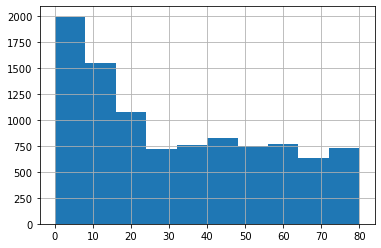

In [62]:
#Checking Age Distribution
cad_df.Age.hist();

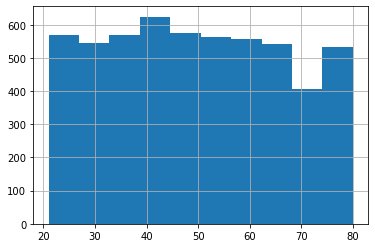

In [63]:
# Keeping individuals ages 21 and over. 
cad_df = cad_df[(cad_df.Age >= 21)]
cad_df.Age.hist();

In [64]:
# Count of remaining null values.
cad_df.isna().sum()

SEQN             0
Age              0
Gender           0
HT              57
WT              54
BMI             67
Race             0
DBP_1          469
DBP_2          286
DBP_3          276
DBP_4         5092
SBP_1          469
SBP_2          286
SBP_3          276
SBP_4         5092
HR            5482
Pulse          180
Arrhythmia     179
HDL            237
LDL           3008
TC             237
TG            2968
Glu            251
FH_MI            0
DTS              5
Smoker        3076
Smoked_100       0
DM               0
MI               0
CAD              0
dtype: int64

### Data Manipulation
In this section data is manipulated for more clarity and better modeling format.
#### Combining Variables
There were four differint blood pressure readings for both systolic blood pressure(SBP) and diastolic blood pressure(DPB). It was determined that the best course of action was to take the average of each reading and combine them into two columns, one for SBP and the other for DBP. This one remove many null values as well as simplify the data for modeling. This is also where the NaNs were useful rather than "None". NaNs allows you to take the average without it resulting as zero or undefined. 

It was also determined to subtract the HDL cholesterol from the the total cholesterol(TC). The original plan was to use LDL cholesterol as one feature and Triglycerides as another feature because high levels of LDL cholesterol and triglycerides are risk factors for CAD. However, for some reason there were a large number of missing values from those columns but not from the HDL and TC columns. It may have actually worked out better this way because TC - HDL, which is considered Non-HDL cholesterol is essentially LDL Cholesterol + Tryglycerides. This gives you basically the same information without the added columns.

The old columns used for the calculations were dropped and the new ones added. Weight(WT) and Height(HT) were also dropped becuase the are both incorporated into BMI.

In [65]:
#Obtaining average blood pressure
avg_sys_bp = cad_df[['SBP_1', 'SBP_2', 'SBP_3', 'SBP_4']].mean(axis=1).round(0)
avg_dia_bp = cad_df[['DBP_1', 'DBP_2', 'DBP_3', 'DBP_4']].mean(axis=1).round(0)


#Obtaining column with just the non-HDL cholesterol
non_hdl = cad_df['TC'] - cad_df['HDL']

#Dropping unnecesary columns
cad_df.drop(columns=['SBP_1', 'SBP_2', 'SBP_3', 'SBP_4', 'DBP_1', 'DBP_2', 'DBP_3', 
                       'DBP_4', 'HR', 'TC', 'TG', 'HDL', 'LDL', 'HT', 'WT', 'SEQN'], inplace=True)

#Inserting new columns at specified locations
cad_df.insert(7, 'SBP', avg_sys_bp)
cad_df.insert(8, 'DBP', avg_dia_bp)
cad_df.insert(12, 'Non_HDL', non_hdl)

cad_df.head()

,Age,Gender,BMI,Race,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,Smoked_100,DM,MI,CAD
0,69.0,1.0,26.7,4.0,86.0,1.0,554.0,113.0,74.0,2.0,600.0,3.0,102.0,1.0,1.0,2.0,2.0
1,54.0,1.0,28.6,3.0,74.0,1.0,219.0,157.0,61.0,2.0,540.0,2.0,120.0,1.0,1.0,2.0,2.0
2,72.0,1.0,28.9,3.0,68.0,1.0,183.0,142.0,82.0,1.0,300.0,3.0,66.0,1.0,1.0,2.0,2.0
4,73.0,2.0,19.7,3.0,92.0,1.0,104.0,137.0,87.0,1.0,480.0,NaN,116.0,2.0,2.0,2.0,2.0
5,56.0,1.0,41.7,1.0,60.0,1.0,104.0,157.0,82.0,2.0,360.0,3.0,188.0,1.0,2.0,1.0,1.0


#### Additional Rows Dropped
Some of the variables had 9s included in them. Which signified "not sure". It was determined to drop these because 1.) I wanted only binary values. 2.) there were only a small number and 3.) if I am predicted whether or not someone has CAD, and they are not sure if they have it, it is not very helpful. So we dropped only variables that were marked as 9 "Not Sure"

In [66]:
#Target feature value counts 
cad_df.CAD.value_counts()

2.0    5243
1.0     224
9.0      15
Name: CAD, dtype: int64

In [67]:
# Droping all columns with code 9.0:"Not Sure"
index9 = cad_df[(cad_df.DM == 9.0) | (cad_df.MI == 9.0) | (cad_df.CAD == 9.0) | (cad_df.FH_MI == 9.0)].index

cad_df.drop(index9, inplace=True)
cad_df.CAD.value_counts(dropna=False)

2.0    5113
1.0     215
Name: CAD, dtype: int64

### Changing values to only binary values of 1 and 0
Foreasier intepretation and better modeling, all the categorical data (other than race), was changed to values of "1" and "0". "1" signifying that they are positive for that conditon and "2" signifying they are negative for that condition. (e.g CAD: "1" = diagnosed with CAD). For Gender, it just means they are "Male".
#### Function to change values to 1 and 0
To have cleaner, more efficient code, the process of changing the variables was performed using a function created for that purpose. The Function takes in a list of variables to be changed and keeps 1 the same (They have the condition) and changes all other values to 0.

In [68]:
#Function that changes all desired categorical data to a binary 1 and 0.
def binaryinator(category_list):
    
    #Loop for categorical variable list
    for cat in category_list:

        # All variables not = 1.0 "present" will change to 0.0 "not present",
        cad_df[cat].mask((cad_df[cat] != 1.0), 0.0, inplace=True)

#### Manually Changing Variables to 1 and 0.
Not all of the variables were able to be changed following the criteria described in the function. These remaining variables were changed each individaully according to the necessary criteria.

In [69]:
#Change categorical data to binary data of 1 and 0 (other than race)

#Category variable list to enter into function.
category_list=['CAD', 'MI', 'DM', 'Gender', 'FH_MI']

#Function for binary categories
binaryinator(category_list)

#Other variables that need to be changed following other criteria

#Changing Arrhythmia code 1.0 "Regular Heartbeat" to 0.0.
cad_df.Arrhythmia.mask((cad_df.Arrhythmia == 1.0), 0.0, inplace=True)

#Changing Arrhythmia code 2.0 "Irregular Heartbeat" to 1.0.
cad_df.Arrhythmia.mask((cad_df.Arrhythmia == 2.0), 1.0, inplace=True)

#Combining codes 1.0 and 2.0 from the "Smoker" column which are "Smokes Everyday" and "Smokes Some Days" to "Smoker" code of 1.0
cad_df.Smoker.mask((cad_df['Smoker']== 2.0), 1.0, inplace=True)

#Changing code 3.0 "Smokes Not At All" to "Non-Smoker" code of 0.0
cad_df.Smoker.mask((cad_df['Smoker']== 3.0), 0.0, inplace=True)

cad_df.head()

,Age,Gender,BMI,Race,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,Smoked_100,DM,MI,CAD
0,69.0,1.0,26.7,4.0,86.0,0.0,554.0,113.0,74.0,0.0,600.0,0.0,102.0,1.0,1.0,0.0,0.0
1,54.0,1.0,28.6,3.0,74.0,0.0,219.0,157.0,61.0,0.0,540.0,1.0,120.0,1.0,1.0,0.0,0.0
2,72.0,1.0,28.9,3.0,68.0,0.0,183.0,142.0,82.0,1.0,300.0,0.0,66.0,1.0,1.0,0.0,0.0
4,73.0,0.0,19.7,3.0,92.0,0.0,104.0,137.0,87.0,1.0,480.0,NaN,116.0,2.0,0.0,0.0,0.0
5,56.0,1.0,41.7,1.0,60.0,0.0,104.0,157.0,82.0,0.0,360.0,0.0,188.0,1.0,0.0,1.0,1.0


In [70]:
#Count of remaining null values to be adressed.
cad_df.isna().sum()

Age              0
Gender           0
BMI             60
Race             0
Pulse          169
Arrhythmia     168
Glu            240
SBP            179
DBP            179
FH_MI            0
DTS              5
Smoker        3000
Non_HDL        226
Smoked_100       0
DM               0
MI               0
CAD              0
dtype: int64

### Imputation of Null Values
All the remaining null values with the exception of the "smoker" column and "Arrythmia" were imputed by taking the mean value of each column based on whether they were male or female and whether they had CAD or not. The Gender was performed separately to account for any differences between them and the mean values for CAD positive and negative individuals was done differently to make a more realistic value to possible result in better model performance. 
#### Imputing the means using a function
A function was created with a forward loop to make this process easier, cleaner, and more efficient. The function takes in a list with the desired variables to be imputed with the mean values.

In [71]:
def cad_mean_imputer(var_list):
    
    #for loop to loop through list of variables to be imputed
    for var in var_list:
        
        #Filters for imputing mean values based on gender and presence of CAD
        male_CAD =  (cad_df.CAD == 1.0) & (cad_df.Gender == 1.0)
        male_noCAD = (cad_df.CAD == 0.0) & (cad_df.Gender == 1.0)
        female_CAD =  (cad_df.CAD == 1.0) & (cad_df.Gender == 0.0)
        female_noCAD = (cad_df.CAD == 0.0) & (cad_df.Gender == 0.0)
        
        #Determine mean values using above filters
        avg_male_CAD = cad_df[male_CAD][var].mean().round(1)
        avg_male_noCAD = cad_df[male_noCAD][var].mean().round(1)
        avg_female_CAD = cad_df[female_CAD][var].mean().round(1)
        avg_female_noCAD = cad_df[female_noCAD][var].mean().round(1)
        
        #Impute mean vales
        cad_df[var].mask(male_CAD & (cad_df[var].isna()), avg_male_CAD, inplace=True)
        cad_df[var].mask(male_noCAD & (cad_df[var].isna()), avg_male_noCAD, inplace=True)
        cad_df[var].mask(female_CAD & (cad_df[var].isna()), avg_female_CAD, inplace=True)
        cad_df[var].mask(female_noCAD & (cad_df[var].isna()), avg_female_noCAD, inplace=True)

In [72]:
# list of variables to impute 
var_list = ['BMI', 'SBP', 'DBP', 'Pulse', 'Glu', 'Non_HDL', 'DTS']

# Imputer function
cad_mean_imputer(var_list)

# Check number of null values remaining.
cad_df.isna().sum()

Age              0
Gender           0
BMI              0
Race             0
Pulse            0
Arrhythmia     168
Glu              0
SBP              0
DBP              0
FH_MI            0
DTS              0
Smoker        3000
Non_HDL          0
Smoked_100       0
DM               0
MI               0
CAD              0
dtype: int64

#### Imputing "Non-smoker" into the "Smoker" Column Using the "Smoked_100 column"
There were two columns that were related to smoking: "Smoker", and "Smoked_100". Both columns came from the questionairre data. The smoker column essentially asked them whether they considered themselves a "Smoker" or "Non-Smoker". The "smoked_100" column asked them whether they smoked more than 100 cigarettes in their lifetime. There were many missing values in the smoker column and so the smoked "Smoked_100" column was used to infer that if a person had smoked less the 100 cigarettes in there lifetime, they were probably a "Non-smoker". Therefore all of the null values in the "Smoker" column were imputed as "non-smoker" for those people who said the smoked less than 100 cigarettes in their lifetime. The "Smoked_100" column was then no longer need and dropped. After this adjustment. There were only 2 null values remaining in the "Smoker" column. Therefore, they were simply dropped as well.

In [73]:
# imputing "Non-Smoker" (code 0.0) for null values in the "Smoker" column by using the "Smoked_100" column 
# for individuals who reported smoking less than 100 cigarettes in there lifetime.
cad_df.Smoker.mask((cad_df['Smoker'].isna()) & (cad_df['Smoked_100'] == 2.0), 0.0, inplace=True, axis=0)

#Dropping "Smoked_100" column
cad_df.drop(columns=['Smoked_100'], inplace=True)

In [74]:
#Checking Remaining Null Value Counts
cad_df.isna().sum()

Age             0
Gender          0
BMI             0
Race            0
Pulse           0
Arrhythmia    168
Glu             0
SBP             0
DBP             0
FH_MI           0
DTS             0
Smoker          2
Non_HDL         0
DM              0
MI              0
CAD             0
dtype: int64

In [75]:
# imputing remaining two nulls as "non-smoker"
cad_df.Smoker = cad_df.Smoker.fillna(0.0)

#### Imputing "Regular Pulse" for Null Values in the "Arrhthmia" Column
The only remaining columns with null values was the "Arththmia" column. Which reports whether the individual has an Irregular pulse or not. Because it is categorical, you cannot impute it with a mean value. The Null values were therore imputed as "Regular Pulse" because that is the majority class and the odds are in favor of a "Regular Pulse"

In [76]:
#Imputing null Values for Arrythmia column as 0.0
cad_df.Arrhythmia = cad_df.Arrhythmia.fillna(0.0)

In [77]:
# Checking Null Value Counts
cad_df.isna().sum()

Age           0
Gender        0
BMI           0
Race          0
Pulse         0
Arrhythmia    0
Glu           0
SBP           0
DBP           0
FH_MI         0
DTS           0
Smoker        0
Non_HDL       0
DM            0
MI            0
CAD           0
dtype: int64

#### Changing Categorical Data Back to Integers
The categorical data was changed backed to integers from floats to be a more clean binary value.

In [78]:
# Convert Data types back to integers for categorical variables
int_columns = {'Age': int,
               'Gender': int,
               'Race': int,
               'Arrhythmia': int,
              'FH_MI': int,
              'Smoker': int,
              'DM': int,
               'MI': int,
              'CAD': int}
cad_df = cad_df.astype(int_columns)
cad_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5328 entries, 0 to 9810
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         5328 non-null   int32  
 1   Gender      5328 non-null   int32  
 2   BMI         5328 non-null   float64
 3   Race        5328 non-null   int32  
 4   Pulse       5328 non-null   float64
 5   Arrhythmia  5328 non-null   int32  
 6   Glu         5328 non-null   float64
 7   SBP         5328 non-null   float64
 8   DBP         5328 non-null   float64
 9   FH_MI       5328 non-null   int32  
 10  DTS         5328 non-null   float64
 11  Smoker      5328 non-null   int32  
 12  Non_HDL     5328 non-null   float64
 13  DM          5328 non-null   int32  
 14  MI          5328 non-null   int32  
 15  CAD         5328 non-null   int32  
dtypes: float64(7), int32(9)
memory usage: 520.3 KB


#### Encoding Race Column to Binary Categories
All the categories of the "Race" column were transformed into binary values using the pandas.get_dummies() method in preparation for modeling.

In [79]:
#Encoding race categories to binary categories
cad_df = pd.get_dummies(cad_df, columns=(['Race']))
cad_df.head()

,Age,Gender,BMI,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,DM,MI,CAD,Race_1,Race_2,Race_3,Race_4,Race_5
0,69,1,26.7,86.0,0,554.0,113.0,74.0,0,600.0,0,102.0,1,0,0,0,0,0,1,0
1,54,1,28.6,74.0,0,219.0,157.0,61.0,0,540.0,1,120.0,1,0,0,0,0,1,0,0
2,72,1,28.9,68.0,0,183.0,142.0,82.0,1,300.0,0,66.0,1,0,0,0,0,1,0,0
4,73,0,19.7,92.0,0,104.0,137.0,87.0,1,480.0,0,116.0,0,0,0,0,0,1,0,0
5,56,1,41.7,60.0,0,104.0,157.0,82.0,0,360.0,0,188.0,0,1,1,1,0,0,0,0


## Model Training and Model Selection
In this section model training and model selection is performed.

#### Defining the Training and Target Features

In [80]:
# Define Target Variable
y = cad_df.CAD

# Drop Target Variable From Data
X = cad_df.drop(columns=('CAD'))
X.head()

,Age,Gender,BMI,Pulse,Arrhythmia,Glu,SBP,DBP,FH_MI,DTS,Smoker,Non_HDL,DM,MI,Race_1,Race_2,Race_3,Race_4,Race_5
0,69,1,26.7,86.0,0,554.0,113.0,74.0,0,600.0,0,102.0,1,0,0,0,0,1,0
1,54,1,28.6,74.0,0,219.0,157.0,61.0,0,540.0,1,120.0,1,0,0,0,1,0,0
2,72,1,28.9,68.0,0,183.0,142.0,82.0,1,300.0,0,66.0,1,0,0,0,1,0,0
4,73,0,19.7,92.0,0,104.0,137.0,87.0,1,480.0,0,116.0,0,0,0,0,1,0,0
5,56,1,41.7,60.0,0,104.0,157.0,82.0,0,360.0,0,188.0,0,1,1,0,0,0,0


#### Train, Test Split and Smote
The data was split into training and test sets prior to training the models. The data was also very imbalanced, therefore in order to address this, the synthetic minority oversampling technique (SMOTE) was used on the training data.

In [81]:
#Split Data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Balance data using the Synthetic Minority Oversampling Technique(SMOTE)
smote = SMOTE()
X_train_smote, y_train_smote,  = smote.fit_resample(X_train, y_train)

#View changes due to smote
print(f'Minority Class before smote: {y_train.value_counts().iloc[1]}')
print(f'Majority Class before smote: {y_train.value_counts().iloc[0]}')
print(f'Minority Class after smote: {y_train_smote.value_counts().iloc[1]}')
print(f'Majority Class after smote: {y_train_smote.value_counts().iloc[0]}')

Minority Class before smote: 171
Majority Class before smote: 3825
Minority Class after smote: 3825
Majority Class after smote: 3825


### Initial Model Training and Model Comparisons
Three differint model algorithms were used to train the data and compare the performance. They were as follows: A decision tree classifier, a random forest classifier, and an XGBoost classifier. The primary metric chosen to evalueate model performance was an F2 score. The F2 Score was chosen because of the imbalanced nature of the data, accuracy is not a great evaluator. Like the F1 score, F2 scores take into account both Precision and Recall but puts more weight on recall. Recall puts a greater emphasis on the number of false Negatives. This is important becase with health data, false negatives are usually the most detrimental(e.g. Model predicts CAD negative, when actually CAD positive). 
#### Functions Used to Train and Compare Models
A function was created to train a generic model and return the performance scores for ease and efficiency. Another function was created that included the first function but looped through a dictionary of functions in order to compare all three functions in a quick, clean and efficient way.

In [82]:
#Function to automatically fits the model, makes predictions on the test data and evaluates the models performance.
def cad_clf(classifier):
    model = classifier
    model.fit(X_train_smote, y_train_smote)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train_smote)
    acc_train = accuracy_score(y_train_smote, y_train_pred)*100
    acc_test = accuracy_score(y_test, y_test_pred)*100
    f2_train = fbeta_score(y_train_smote, y_train_pred, beta=2.0)*100
    f2_test = fbeta_score(y_test, y_test_pred, beta=2.0)*100
    cm = confusion_matrix(y_test, y_test_pred)
    print(f'''Accuracy of Predictions on Training Data: {round(acc_train, 2)}
Accuracy of Predictions on Test Data: {round(acc_test, 2)}
                                 ''')
    print(f'''F2 Score for Training Data: {round(f2_train, 2)}
F2 Score for Test Data: {round(f2_test, 2)}
                    ''')
    print('Confusion Matrix Numbers for Test Data')
    print(' ')
    print(f'''True Negatives: {cm[0][0]}
False Negatives: {cm[1][0]}
False Positives: {cm[0][1]}
True Positives: {cm[1][1]}
 ''')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_disp.plot()
    plt.title(f'Confusion Matrix')
    plt.show()

In [83]:
#Function that takes in a classifie dictionary with the names as keys and classifiers as values to compare classifiers
def cad_clf_compare(clf_dict):
    classifiers = clf_dict
    for i in range(len(clf_dict)):
        print('---------------------------')
        print(list(clf_dict.keys())[i])
        print('---------------------------')
        cad_clf(list(clf_dict.values())[i])

#### Comparing Initial Model Performance
The intial model results (No hyperparameter adjustments) usually put the XGBoost slightly ahead based on F2 Score (approx 27). 

---------------------------
Decision Tree Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 91.37
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 31.8
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1199
False Negatives: 26
False Positives: 89
True Positives: 18
 


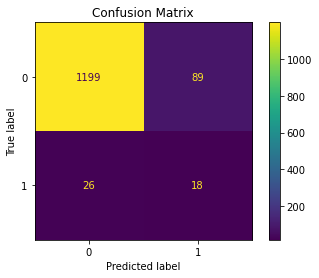

---------------------------
Random Forest Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 94.07
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 23.61
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1242
False Negatives: 33
False Positives: 46
True Positives: 11
 


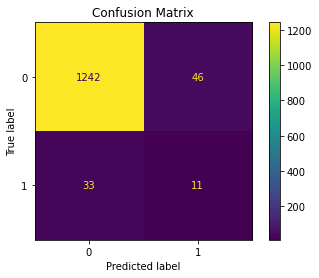

---------------------------
XGBoost Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 95.35
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 29.55
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1257
False Negatives: 31
False Positives: 31
True Positives: 13
 


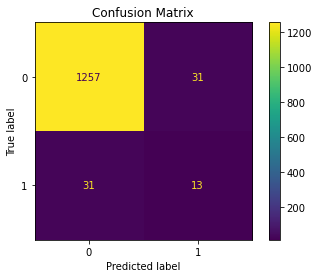

In [84]:
#Classifier Dictionary
clf_dict = {'Decision Tree Classifier': DecisionTreeClassifier(), 'Random Forest Classifier': RandomForestClassifier(), 'XGBoost Classifier': XGBClassifier()}

#Compare classifiers using function
cad_clf_compare(clf_dict)

### Feature Selection by Feature Importances
After initial model results, feature selection was performed based on the feature importances method. 
#### Feature Importances Functions for Comparing Models
As before, two functions were created for ease, code cleanliness, and efficieny. One to plot feature importances and one to compare models.

In [85]:
#Function to take in model and display the feature importances.
def ftr_imp(model):
    n_features = X_train_smote.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_smote.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.show()

In [86]:
#function that takes dictionary of models and compares them best on their feature importances.
def ftr_imp_comp(clf_dict):
    for i in range(len(clf_dict)):
        print(f'                          {list(clf_dict.keys())[i]}')
        ftr_imp(list(clf_dict.values())[i])
        print('''          ----------------------------------------------------------
        ''');

                          Decision Tree Classifier


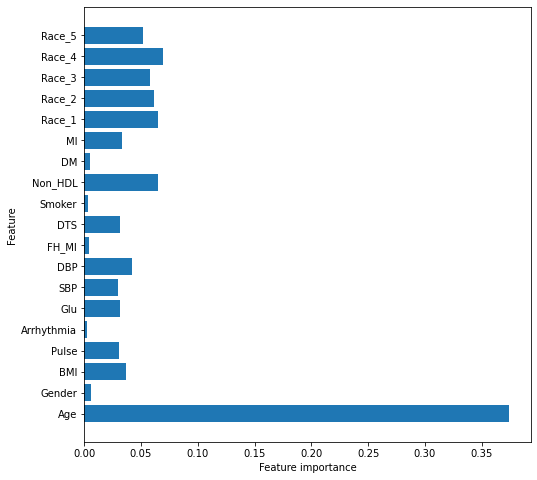

          ----------------------------------------------------------
        
                          Random Forest Classifier


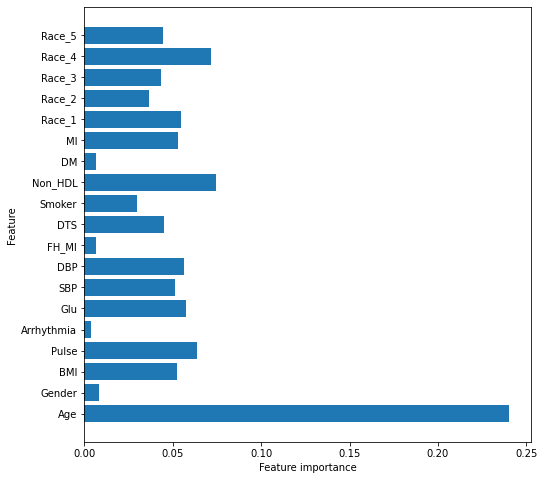

          ----------------------------------------------------------
        
                          XGBoost Classifier


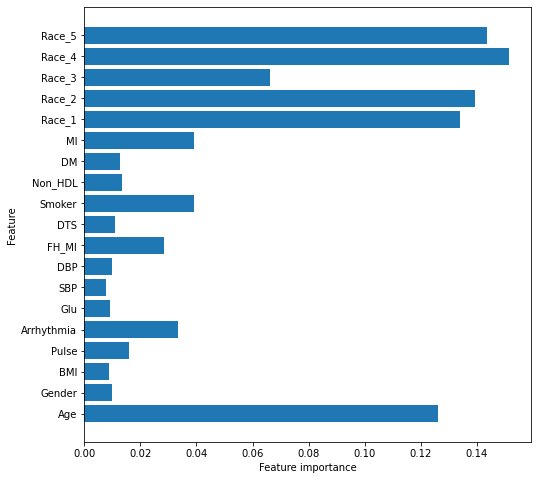

          ----------------------------------------------------------
        


In [87]:
#Use ftr_imp_comp model to compare feature importances of the three classifiers
ftr_imp_comp(clf_dict)

### Model Training and Model Comparisons on New Set of Features
Based on the feature importance comparisons. It was determined to drop the following columns: DM (Diabetes), FH_MI(family history of miocardial infarction), Arrhythmia(irregular heartbeat), and Gender due to there low importance numbers across all models. All three models were then trained on the new data and compared. 

---------------------------
Decision Tree Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 90.54
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 32.09
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1187
False Negatives: 25
False Positives: 101
True Positives: 19
 


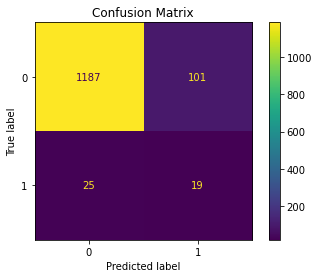

---------------------------
Random Forest Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 94.97
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 40.08
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1246
False Negatives: 25
False Positives: 42
True Positives: 19
 


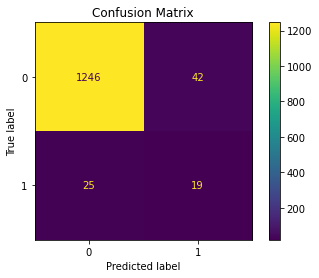

---------------------------
XGBoost Classifier
---------------------------
Accuracy of Predictions on Training Data: 100.0
Accuracy of Predictions on Test Data: 96.02
                                 
F2 Score for Training Data: 100.0
F2 Score for Test Data: 32.86
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1265
False Negatives: 30
False Positives: 23
True Positives: 14
 


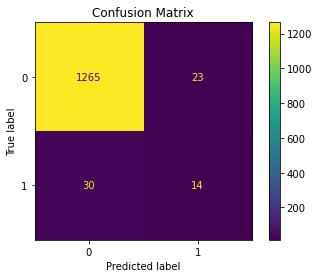

In [88]:
#Test Model Performance based on new features

#drop columns based on feature importances results
cad_df.drop(columns=(['DM', 'FH_MI', 'Arrhythmia', 'Gender']), inplace=True)

# Define Target Variable
y = cad_df.CAD

# Drop Target Variable From Data
X = cad_df.drop(columns=('CAD'))

#Split Data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Balance data using the Synthetic Minority Oversampling Technique(SMOTE)
smote = SMOTE()
X_train_smote, y_train_smote,  = smote.fit_resample(X_train, y_train)

#Use function to compare models based on new features
cad_clf_compare(clf_dict)

### Hyperparameter Optimization
Based on the previous results. Random Forest had the highest F2 score and was chosen to have further hyperparameter adjustments in order to improve the F2 score and lower the rate of false negatives.
#### RandomizedSearchCV Hyperparameter Optimization
In order to efficientally select more optimal hyperparameter, RandomizedSearchCV was used. It was originally plan to us GridSearchCV but due to the time and resources required to use GridSearchCV, RandomizedSearchCV was chosen as the best alternative.

In [89]:
#Perform a RandomizedSearchCV to find more optimal Hyperparameters Tuning

#Make an f2 scorer to perform a randomizedSearchCV for hyperparameter tuning
f2_scorer = make_scorer(fbeta_score, beta=2, greater_is_better = True)

#define parameter criteria for RandomizedSearch CV
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'n_estimators': range(50,150,25),
    'max_depth': range(2,20,2),
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': range(1,10,1),
    'min_samples_split': range(2,10,1)
}

rf_rs_f2 = RandomizedSearchCV(estimator=RandomForestClassifier(),
                 param_distributions=param_grid,
                 n_iter=25,
                 scoring=f2_scorer,
                 random_state=42)

# Perform the hyperparameter tuning with random search
rf_rs_f2.fit(X_train_smote, y_train_smote)

# List best parameter findings
rf_rs_f2.best_params_

{'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 16,
 'criterion': 'entropy'}

### Final Model Results
Hyperparameteroptimization was able to improve both the F2 score while minimizing the rate of False Positives. 

Accuracy of Predictions on Training Data: 98.58
Accuracy of Predictions on Test Data: 93.24
                                 
F2 Score for Training Data: 98.95
F2 Score for Test Data: 44.44
                    
Confusion Matrix Numbers for Test Data
 
True Negatives: 1218
False Negatives: 20
False Positives: 70
True Positives: 24
 


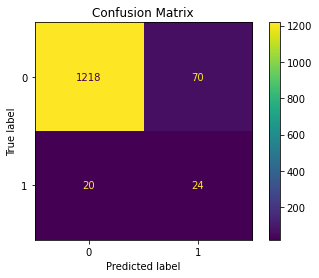

In [37]:
#Define a classifier with the best parameters found in RandomizedSearchCV these parameters
rf_hyp_opt = RandomForestClassifier(n_estimators=100, min_samples_split= 8, min_samples_leaf= 2, max_features='sqrt', max_depth=16, criterion='entropy')

#Use training Function to fit and test new model.
cad_clf(rf_hyp_opt)

## Conclusion
A Random Forest Classifier performed the best at minimizing the rate of false negatives while predicting the presence of coronary artert disease in adult patients using the NHANES data. The Final F2 Score came out to be about 44 with about 20 False negatives. Although there is still room for a better model performance. A Random Forest Classifier is a powerful way to detect the possible presence of coronary artery disease in adults, ultimately leading to more lives saved, less strain on the healthcare system and more money saved. 